In [3]:
#Load data
import torch
import torchvision
import torchvision.transforms as transforms


#transform like epretrained model
from torchvision import transforms

transform = transforms.Compose([            #[1]
transforms.Resize(256),                    #[2]
transforms.CenterCrop(224),                #[3]
transforms.ToTensor(),                     #[4]
transforms.Normalize(                      #[5]
mean=[0.485, 0.456, 0.406],                #[6]
std=[0.229, 0.224, 0.225]                  #[7]
)])

batch_size = 1000

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

dataloaders = {
    "train": trainloader,
    "val": testloader,
}


Files already downloaded and verified
Files already downloaded and verified


In [4]:
#Load pretrained Model
import torchvision.models as models

resnet18 = models.resnet18(pretrained= True)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

torch.Size([1000, 3, 224, 224])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
tensor(1)


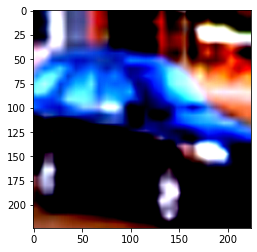

In [6]:
#get a test image

#0 airplane 										
#1 automobile 										
#2 bird 										
#3 cat 										
#4 deer 										
#5 dog 										
#6 frog 										
#7 horse 										
#8 ship 										
#9 truck

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


batch = next(iter(dataloaders['train']))
print(batch[0].shape)
plt.imshow(batch[0][0].permute(1, 2, 0)) # image an der ersten stelle
print(batch[1][0]) # label an der ersten stelle
plt.show()

Our pretrained model has 1000 output layers we need to fit them to ur Problem(CIFAR10) so 10 output layers


We'll change the last linearlayer with model.fc | check the model parameters to get number of inputs


We also dont want to train the previous layer only the new layer. So we set .requires_grad to False

In [4]:
def set_parameter_requires_grad(model, feature_extracting = True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(resnet18)

In [11]:
# inizialise the linear layer
import torch.nn as nn
resnet18.fc = nn.Linear(512, 10)


In [12]:
# Check which layer in the model that will compute the gradient
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0026, -0.0058,  0.0174,  ...,  0.0016, -0.0150, -0.0174],
        [-0.0124,  0.0135,  0.0160,  ...,  0.0058,  0.0065, -0.0017],
        [ 0.0430, -0.0423, -0.0413,  ...,  0.0258,  0.0249,  0.0215],
        ...,
        [-0.0044, -0.0327, -0.0282,  ..., -0.0352,  0.0126, -0.0099],
        [ 0.0306, -0.0351,  0.0207,  ..., -0.0301, -0.0051,  0.0234],
        [-0.0393,  0.0418,  0.0152,  ...,  0.0275,  0.0124,  0.0168]])
fc.bias tensor([-0.0108,  0.0306,  0.0390,  0.0223, -0.0103,  0.0374, -0.0320,  0.0407,
        -0.0171,  0.0239])


In [13]:
#Train the model 
import time
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=25, is_train=True):
    since = time.time()
    
    acc_history = []
    loss_history = []

    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            model.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            # backward
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        
        torch.save(model.state_dict(), os.path.join('/kaggle/working/', '{0:0=2d}.pth'.format(epoch)))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    return acc_history, loss_history


In [15]:
# Here we only want to update the gradient for the classifier layer that we initialized. 
# settings so only the last layer is trained
from torch.optim import Adam

params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
            
optimizer = Adam(params_to_update)


	 fc.weight
	 fc.bias


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup the loss function
#verschidene kriterien
criterion = nn.CrossEntropyLoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.CrossEntropyLoss()

#uncertenty auch
#True False

# Train model
train_acc_hist, train_loss_hist = train_model(resnet18, dataloaders["train"], criterion, optimizer, device)

NameError: name 'nn' is not defined

In [10]:
print(len(dataloaders["val"]))

10


In [11]:
import glob #https://docs.python.org/3/library/glob.html

def eval_model(model, dataloaders, device):
    since = time.time()
    
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('/kaggle/working/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)

        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Acc: {:.4f}'.format(epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())

        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    return acc_history

In [ ]:


val_acc_hist = eval_model(resnet18, test_loader, device)



In [ ]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

In [ ]:
plt.plot(train_loss_hist)
plt.show()